# Question 3

In [174]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import control
import math
plt.style.use('ggplot')
from sympy.solvers import solve
from sympy import Symbol
import sympy as sp

We define a few helper functions ...

In [175]:
def get_params(Mp,ts):
    '''
    Mp in percent
    '''

    x = np.log(Mp/100)**2
    zeta = x / (x + np.pi**2)
    zeta = np.sqrt(zeta)

    wn = 4/ts/zeta 

    return zeta, wn

def polar(z):
    '''
    Get polar representation
    '''
    a= z.real
    b= z.imag
    r = math.hypot(a,b)
    theta = math.atan2(b,a)
    return r,theta # use return instead of print.

def get_poles(zeta,wn):
    '''
    Get poles f4om
    '''
    return (complex(-zeta*wn, wn*np.sqrt(1-zeta**2)), complex(-zeta*wn ,- wn*np.sqrt(1-zeta**2)))

def get_alpha(gamma, theta, phi):
    '''
    Returns alpha from gamma.
    
    All angles in radians
    '''
    num = np.sin(gamma) * np.sin(theta + gamma + phi)
    denom = np.sin(theta + gamma) * np.sin(gamma + phi)
    return num/denom

def get_zc(wn, gamma, theta):
    '''
    Get zc
    '''
    num = wn* np.sin(gamma)
    denom = np.sin(theta + gamma)
    return num/denom

We design for $M_p$ = 5 %, and $T_s$ is 0.02s, $K_v$ is 1%. And we shall test if the design satisifies for $T_r$.

In [176]:
Mp, ts = 5, 0.02
zeta,wn = get_params(Mp,ts)
print(f"Zeta {zeta} wn {wn}")
p1,p2 = get_poles(zeta,wn)
print(f"Required dominant poles {p1}, {p2}")

Zeta 0.6901067305598216 wn 289.8102440440741
Required dominant poles (-200.00000000000003+209.73787820249777j), (-200.00000000000003-209.73787820249777j)


## Part a

This is feasible if (-200.00 +/- 209.737j) lies on the root locus, as dominant poles.

In [177]:
sys = control.TransferFunction([240,240],[1,10,24,0])
print(f"System open loop is {sys}")

System open loop is 
    240 s + 240
-------------------
s^3 + 10 s^2 + 24 s



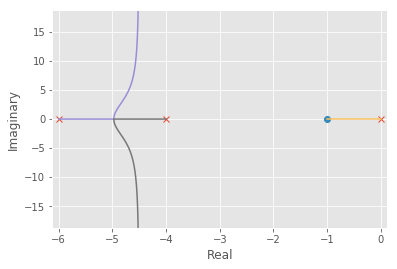

In [178]:
control.root_locus(sys);

Hence choice 1 is not feasible.

## Part b

We first analyse the existent system, understand if the transient parameters need improvement or the steady state. We then desgin appropriately, with the dominant pole assumption.

With $􏰍 G_c(s)=K_c \alpha* (1 + Ts)/(1+\alpha*Ts)$.

Needed $K_v$ is 100 (1% error).
Current $K_v$ is 10. 

Hence, $K_c * \alpha = 10$.

We determine $\theta$, angle of compensation needed at (-200, +/- 209.73)

In [179]:
polar(control.evalfr(sys, complex(200,-209.73)))[1] 

1.596108226418121

In [180]:
np.pi - 1.596108226418121

1.5454844271716721

We need -88.54 deg as compensation.

Besides this, we need to meet:

* Angle sum = $\pi$
* Magnitude at roots = 1
* $K_c * \alpha = 10$

We treat this as a lead compensation case.

In [209]:
phi = 85.97404456267036 * np.pi/180
theta = np.arccos(zeta)
gamma = (1.596108226418121 - theta)/2
print(f"Gamma {gamma * 180/np.pi}")
alpha = get_alpha(gamma = gamma, phi = phi, theta = theta)
print(f"Alpha {alpha}")
temp_sys = alpha * control.TransferFunction([T,1],[T*alpha, 1]) * sys
Kc = 1/polar(control.evalfr(temp_sys,complex(-200,209.73)))[0]
print(f"Kc {Kc}")

Gamma 22.54441156486525
Alpha 0.183975416417848
Kc 752.8216104925237


To determine $T$, we use the magnitude condition.

In [197]:
cur_mag = polar(control.evalfr(sys, complex(-200,209.73)))[0]
print(f"Current magnitude without compensator at requisite roots {cur_mag}")

Current magnitude without compensator at requisite roots 0.002919450489681809


In [183]:
zc = get_zc(wn, gamma = gamma, theta = theta)
print(f"Z_c {zc}")
T = 1/zc
print(f"T {T}")

Z_c 119.09350502020902
T 0.00839676353324482


In [203]:
print("Solved parameters : \n")
print(f"Alpha {alpha}")
print(f"Kc {Kc}")
print(f"T {T}")

Solved parameters : 

Alpha 0.183975416417848
Kc 54.355088275967454
T 0.00839676353324482


## Part 3

We perform a grid search, while looking for the following:

* Angle sum = $\pi$
* Magnitude at roots = 1
* $K_c * \alpha = 10$

We keep varying $\alpha$ and $T$.

We try:

* grid search
* gradient descent

In [216]:
aa = np.arange(0.1,2.0,(0.2-0.1)/1000)
tt = np.arange(0, 0.01, 0.01/100)
ll = [] # loss array

def loss1(a,t, pole = complex(-200,209.73)):
    '''
    Angle compensation
    '''
    diff = polar(1 + t*pole)[1] - polar(1 + a*t*pole)[1] - 1.5454844271716721
    diff = np.abs(diff)
    return diff

def loss2(a,t, pole = complex(-200,209.73)):
    '''
    Magnitude compensation
    '''
    diff = polar(1 + t*pole)[0] / polar(1 + a*t*pole)[0] - 1/(10*cur_mag)
    return np.abs(diff)

def loss(a,t, pole = complex(-200,209.73)):
    return loss1(a,t, pole) + 0*loss2(a,t,pole)

l_min = None
a_min = None
t_min = None

for a in aa:
    for t in tt:
        l = loss(a,t)
        if not l_min or (l_min > l):
            l_min = l
            a_min = a
            t_min = t
        ll.append(loss)
        
print(f"Loss {l_min} a_min {a_min} t_min {t_min}")
print(f"Angle loss {loss1(a_min,t_min)}")
#print(f"Mag loss {loss2(a_min, t_min)}")

Loss 1.884514472694221e-06 a_min 0.16690000000000194 t_min 0.0077
Angle loss 1.884514472694221e-06
Mag loss 32.09852385559125


## Part 4,5 with Part 2

Clearly, we have used a lead compensator.

The compensated transfer function is:

In [210]:
comp = Kc * alpha * control.TransferFunction([T,1],[T*alpha, 1])
print(f"Compensator {comp}")
comp_sys = sys* comp
print(f"Final Sys {comp_sys}")

Compensator 
1.163 s + 138.5
---------------
0.001545 s + 1

Final Sys 
    279.1 s^2 + 3.352e+04 s + 3.324e+04
-------------------------------------------
0.001545 s^4 + 1.015 s^3 + 10.04 s^2 + 24 s



The transient responses associated with this are:

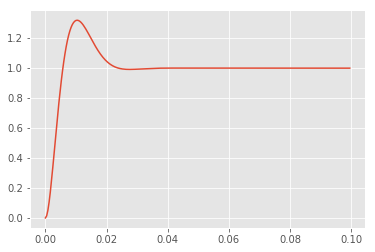

In [212]:
tt, yy = control.step_response(control.feedback(comp_sys), T = np.arange(0,0.1,0.04/100))
plt.plot(tt,yy)

## Part 4,5 with Part 3

Clearly, we have used a lead compensator.

The compensated transfer function is:


In [217]:
temp_sys = a_min * control.TransferFunction([t_min,1],[t_min*a_min, 1]) * sys
Kc = 1/polar(control.evalfr(temp_sys,complex(-200,209.73)))[0]

comp2 = Kc * a_min * control.TransferFunction([t_min,1],[t_min*a_min, 1])
print(f"Compensator {comp2}")
comp_sys2 = sys* comp2
print(f"Final Sys {comp_sys2}")

Compensator 
1.224 s + 159
--------------
0.001285 s + 1

Final Sys 
    293.8 s^2 + 3.845e+04 s + 3.816e+04
-------------------------------------------
0.001285 s^4 + 1.013 s^3 + 10.03 s^2 + 24 s



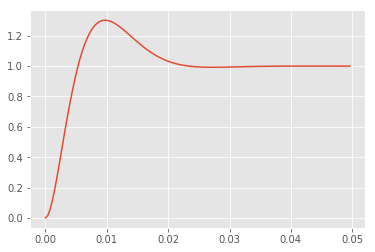

In [219]:
tt, yy = control.step_response(control.feedback(comp_sys2), T = np.arange(0,0.05,0.04/100))
plt.plot(tt,yy)

Which has a much smaller $T_s$. We also note that in the above two cases, no lag compensation is needed, since the $K_v$ obtained is good enough.